In [ ]:
from pylabeledrf.computeLRF import *
import dendropy
from dendropy.calculate import treecompare
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random

In [149]:
taxa = dendropy.TaxonNamespace()
#p53 = dendropy.Tree.get_from_path('NOX4.Ensembl99.nhx','newick', taxon_namespace=taxa, rooting='force-rooted')
p53 = dendropy.Tree.get_from_path('NOX4.Ensembl99.nhx','newick', taxon_namespace=taxa, rooting='force-unrooted')

In [150]:
t1 = parseEnsemblLabels(p53)
t2 = mutateLabeledTree(t1.clone(depth=1), 20, model='LRF')
randn = t2.find_node_for_taxon(random.choice(taxa))
t2.reroot_at_edge(randn.edge)
t2.is_rooted = False


INFO:root:#flips 8 #col 12, #exp 0


In [152]:
computeLRF(t1,t2)
computeLRF_old(t1,t2)

INFO:root:RF dist: 12 | Label subst: 7 | Total LRF: 19

INFO:root:Substitution needed between 106 and 0
INFO:root:Substitution needed between 98 and 11
INFO:root:Substitution needed between 99 and 12
INFO:root:Collapses needed between islands 119 and 32: 2+0
INFO:root:Collapses needed between islands 161 and 159: 1+0
INFO:root:Substitution needed between 138 and 51
INFO:root:Collapses needed between islands 25 and 115: 1+0
INFO:root:Collapses needed between islands 128 and 41: 1+0
INFO:root:Substitution needed between 47 and 137
INFO:root:Collapses needed between islands 149 and 147: 1+0
INFO:root:Collapses needed between islands 55 and 53: 1+0
INFO:root:Substitution needed between 41 and 131
INFO:root:Substitution needed between 20 and 110
INFO:root:Collapses needed between islands 58 and 56: 1+0
INFO:root:Collapses needed between islands 155 and 153: 1+0
INFO:root:Collapses needed between islands 78 and 76: 1+0
INFO:root:Collapses needed between islands 77 and 75: 1+0
INFO:root:Subst

20

In [ ]:
def computeLRF(intree1,intree2):
    """
    Function to compute exactly the Labeled Robinson-Foulds (LRF) distance.

    Trees need to have their inner nodes with a label attribute "speciation"
    or "duplication". To correctly process gene trees from Ensembl, use the
    :func:`parseEnsemblLabels`.

    :param intree1: a labeled tree as Dendropy object
    :param intree2: a labeled tree as Dendropy object
    """

    # This implementation builds upon the datastructure and ideas of
    #    William HE Day, Optimal algorithms for comparing trees with 
    #    labeled leaves
    #    J Classification 2:7–28. 1985. doi: 10.1007/BF01908061


    # Define the table X  according to (Day 1985) to have contiguous integers for
    # each clade, and define a clade by the left-most and right-most identifiers,
    # such as [4,7] for the clade [4,5,6,7].
    # 
    # Note we extend the table to contain the following fields, which will be 
    # populated later in the algorithm:
    #  3: node defining the clade in T1
    #  4: node defining the clade in T2 
    #  5: size of the island rooted in the clade in T1
    #  6: size of the island rooted in the clade in T2 
    #  7: labels in the island rooted in the clade in T1
    #  8: labels in the island rooted in the clade in T2
    def buildX(T):
        X = []
        n = len(T.leaf_nodes())
        tax2id = {}
        n2bip = {}

        def buildX_r(T):
            if T.is_leaf():
                # left right id2taxon nodeT1 nodeT2 sizeIsland1 sizeIsland2 labels1 labels2
                X.append([0,0,T.taxon,0,0,0,0,set(),set()])
                i = len(X)-1
                tax2id[T.taxon] = i
                return(i,i)
            else:
                min_l=n
                max_r=0
                for c in T.child_node_iter():
                    l,r = buildX_r(c)
                    min_l=min(l,min_l)
                    max_r=max(r,max_r)
                X[min_l][0]=X[max_r][0]=min_l
                X[min_l][1]=X[max_r][1]=max_r
                X[min_l][3]=X[max_r][3]=T
                n2bip[T]=[min_l,max_r]
                return(min_l,max_r)
        buildX_r(T.seed_node)
        return(X,tax2id,n2bip)

    # findgood() identifies the good edge in T2 and generates the 
    # node-to-clade hash table 
    def findgood(T,X,tax2id):
        n2bip = {}
        n = len(T.leaf_nodes())
        def findgood_r(t):
            if t.is_leaf():
                i = tax2id[t.taxon]
                return(i,i,1)
            else:
                min_l=n
                max_r=0
                tot_w=0
                for c in t.child_node_iter():
                    l,r,w = findgood_r(c)
                    min_l=min(l,min_l)
                    max_r=max(r,max_r)
                    tot_w+=w
                if max_r-min_l+1 == tot_w:
                    if (X[min_l][0]==min_l and X[min_l][1]==max_r):
                        X[min_l][4]=t
                        n2bip[t]=[min_l,max_r]
                    elif (X[max_r][0]==min_l and X[max_r][1]==max_r):
                        X[max_r][4]=t
                        n2bip[t]=[min_l,max_r]                                                                                                                                              
                return(min_l,max_r,tot_w)                                                                                                                                                   
        findgood_r(T.seed_node)                                                                                                                                                             
        return(n2bip)                                                                                           
       # this function is used to identify the islands and update the table X 
    # with the relevant labels and sizes
    def getIslandsDay(t,X,n2bip,isT1):

        # An island is separated from the rest of the tree
        # by good edges. In the traversal below, we do a preorder
        # traversal and create a new island whenever we meet a clade
        # defined in X
        #                         ____
        #                        /
        #                 **** x6
        #                *       \___
        #         **** x3                ......
        #        *       \___    ______x7
        #   ----x1              /        ...
        #        *       **** x4        ____
        #         **** x2       ``--    /
        #                *********** x5
        #                              \_____
        #

        n = len(X)
        off = 5 if isT1 else 6

        def mytraversal(t,is_rooted,parentIslandId=0):

            if t.is_leaf():
                return()
            try:
                [l,r] = n2bip[t]
            except KeyError:
                l=r=0 #dummy value that will fail retrieval in X

            row=-1
            if (X[l][0]==l and X[l][1]==r and X[l][4]!=0):
                row=l
            elif (X[r][0]==l and X[r][1]==r and X[r][4]!=0):
                row=r

            # clade is in common (i.e. valid entry in X)
            if row > -1:
                # end of previous island, so new island. 
                islandId = row
                X[row][off+2].add(t.label)
                for c in t.child_node_iter():
                    mytraversal(c,is_rooted,islandId)
            else:
                # continue previous island
                islandId = parentIslandId
                # we process the node unless it's the fake root of an unrooted tree:
                if not is_rooted and len(t.adjacent_nodes()) == 2:
                    if t.label != None:
                        warnings.warn('The root of an unrooted tree should not have a label')
                else:
                    X[islandId][off+2].add(t.label)
                    X[islandId][off] += 1

                for c in t.child_node_iter():
                    mytraversal(c,is_rooted,islandId)

        mytraversal(t.seed_node, t.is_rooted)
        return()

    # check that the taxon namespace is consistent
    if t1.taxon_namespace != t2.taxon_namespace:
        raise ValueError('Cannot compare trees defined with different taxon_namespace')
    else:
        taxa = t1.taxon_namespace

    # convert unrooted to rooted trees
    if not t1.is_rooted() and not t2.is_rooted():
        myt1=t1.clone(depth=1)
        myt2=t2.clone(depth=1)

        node_n1 = myt1.find_node_for_taxon(taxa[-1])
        myt1.reroot_at_edge(node_n1.edge)
        myt1.prune_taxa([taxa[-1]])
        node_n2 = myt2.find_node_for_taxon(taxa[-1])
        myt2.reroot_at_edge(node_n2.edge)
        myt2.prune_taxa([taxa[-1]])

    elif t1.is_rooted() and t2.is_rooted():
        myt1=t1.clone(depth=1)
        myt2=t2.clone(depth=1)
    else:
        raise TypeError('Cannot compare a rooted tree with an unrooted tree.')

    X, tax2id, n12bip = buildX(myt1)
    n22bip = findgood(myt2,X,tax2id)
    getIslandsDay(myt1,X,n12bip,True)
    getIslandsDay(myt2,X,n22bip,False)
    rf = subs = 0
    for i in X:
        if i[4] != 0:
            rf += i[5]+i[6]
            if len(i[7].intersection(i[8])) == 0:
                subs +=1

    logging.info('RF dist: %d | Label subst: %d | Total LRF: %d\n' % (rf,subs,rf+subs))
    return(rf+subs)

In [ ]:
def buildX(T):
    X = []
    n = len(T.leaf_nodes())
    tax2id = {}
    n2bip = {}

    def buildX_r(T):
        if T.is_leaf():
            # left right id2taxon nodeT1 nodeT2 sizeIsland1 sizeIsland2 labels1 labels2
            X.append([0,0,T.taxon,0,0,0,0,set(),set()])
            i = len(X)-1
            tax2id[T.taxon] = i
            return(i,i)
        else:
            min_l=n
            max_r=0
            for c in T.child_node_iter():
                l,r = buildX_r(c)
                min_l=min(l,min_l)
                max_r=max(r,max_r)
            X[min_l][0]=X[max_r][0]=min_l
            X[min_l][1]=X[max_r][1]=max_r
            X[min_l][3]=X[max_r][3]=T
            n2bip[T]=[min_l,max_r]
            return(min_l,max_r)
    buildX_r(T.seed_node)
    return(X,tax2id,n2bip)

def findgood(T,X,tax2id):
    n2bip = {}
    n = len(T.leaf_nodes())
    def findgood_r(t):
        if t.is_leaf():
            i = tax2id[t.taxon]
            return(i,i,1)
        else:
            min_l=n
            max_r=0
            tot_w=0
            for c in t.child_node_iter():
                l,r,w = findgood_r(c)
                min_l=min(l,min_l)
                max_r=max(r,max_r)
                tot_w+=w
            if max_r-min_l+1 == tot_w:
                if (X[min_l][0]==min_l and X[min_l][1]==max_r):
                    X[min_l][4]=t
                    n2bip[t]=[min_l,max_r]
                elif (X[max_r][0]==min_l and X[max_r][1]==max_r):
                    X[max_r][4]=t
                    n2bip[t]=[min_l,max_r]
            return(min_l,max_r,tot_w)
    findgood_r(T.seed_node)
    return(n2bip)
def getIslands2(t,X,n2bip,isT1):

    #                         ____
    #                        /
    #                 **** x6
    #                *       \___
    #         **** x3                ......
    #        *       \___    ______x7
    #   ----x1              /        ...
    #        *       **** x4        ____
    #         **** x2       ``--    /
    #                *********** x5
    #                              \_____
    #


    n = len(X)
    off = 5 if isT1 else 6

    def mytraversal(t,is_rooted,parentIslandId=0):

        if t.is_leaf():
            return()

        try: 
            [l,r] = n2bip[t]
        except KeyError:
            l=r=0 #dummy value 
        row=-1

        if (X[l][0]==l and X[l][1]==r and X[l][4]!=0):
            row=l
        elif (X[r][0]==l and X[r][1]==r and X[r][4]!=0):
            row=r

        # clade is in common 
        if row > -1:
            # end of previous island, so new island. 
            islandId = row
            X[row][off+2].add(t.label)
            for c in t.child_node_iter():
                mytraversal(c,is_rooted,islandId)
        else:
            # continue previous island
            islandId = parentIslandId
            # we process the node unless it's the fake root of an unrooted tree:
            if not is_rooted and len(t.adjacent_nodes()) == 2:
                if t.label != None:
                    warnings.warn('The root of an unrooted tree should not have a label')
            else:
                X[islandId][off+2].add(t.label)
                X[islandId][off] += 1

            for c in t.child_node_iter():
                mytraversal(c,is_rooted,islandId)

    mytraversal(t.seed_node, t.is_rooted)
    return()


In [162]:
nsamples = 10
ndist = 20
taxa = dendropy.TaxonNamespace()
p53 = dendropy.Tree.get_from_path('NOX4.Ensembl99.nhx','newick', taxon_namespace=taxa)
t1 = parseEnsemblLabels(p53)
t = t1.clone(depth=1)
#t = cloneAndReroot(t1)

random.seed(13)
abort = False
res_rf = []
res_s = []

logging.root.level = 40
for i in range(0,ndist):
    res_rf.append([])
    res_s.append([])
    for j in range(0,nsamples):
        t2 = mutateLabeledTree(t.clone(depth=1), i, model='LRF')
        res_s[i].append(computeLRF(t,t2))
        res_rf[i].append(treecompare.symmetric_difference(t,t2))

#res = []
#logging.root.level = 40
#for i in range(0,ndist):
#    res.append([])
#    for j in range(0,nsamples):
#        t2 = mutateLabeledTree(t.clone(depth=1), i, model='ELRF')        
#        res[i].append(computeELRF(t,t2))

INFO:root:#flips 0 #col 0, #exp 0
INFO:root:RF dist: 0 | Label subst: 0 | Total LRF: 0

INFO:root:#flips 0 #col 0, #exp 0
INFO:root:RF dist: 0 | Label subst: 0 | Total LRF: 0

INFO:root:#flips 0 #col 0, #exp 0
INFO:root:RF dist: 0 | Label subst: 0 | Total LRF: 0

INFO:root:#flips 0 #col 0, #exp 0
INFO:root:RF dist: 0 | Label subst: 0 | Total LRF: 0

INFO:root:#flips 0 #col 0, #exp 0
INFO:root:RF dist: 0 | Label subst: 0 | Total LRF: 0

INFO:root:#flips 0 #col 0, #exp 0
INFO:root:RF dist: 0 | Label subst: 0 | Total LRF: 0

INFO:root:#flips 0 #col 0, #exp 0
INFO:root:RF dist: 0 | Label subst: 0 | Total LRF: 0

INFO:root:#flips 0 #col 0, #exp 0
INFO:root:RF dist: 0 | Label subst: 0 | Total LRF: 0

INFO:root:#flips 0 #col 0, #exp 0
INFO:root:RF dist: 0 | Label subst: 0 | Total LRF: 0

INFO:root:#flips 0 #col 0, #exp 0
INFO:root:RF dist: 0 | Label subst: 0 | Total LRF: 0

INFO:root:#flips 1 #col 0, #exp 0
INFO:root:RF dist: 0 | Label subst: 1 | Total LRF: 1

INFO:root:#flips 0 #col 1, #exp 

INFO:root:RF dist: 6 | Label subst: 3 | Total LRF: 9

INFO:root:#flips 1 #col 8, #exp 0
INFO:root:RF dist: 8 | Label subst: 1 | Total LRF: 9

INFO:root:#flips 1 #col 8, #exp 0
INFO:root:RF dist: 8 | Label subst: 1 | Total LRF: 9

INFO:root:#flips 3 #col 6, #exp 0
INFO:root:RF dist: 6 | Label subst: 3 | Total LRF: 9

INFO:root:#flips 3 #col 6, #exp 0
INFO:root:RF dist: 6 | Label subst: 3 | Total LRF: 9

INFO:root:#flips 1 #col 8, #exp 0
INFO:root:RF dist: 8 | Label subst: 1 | Total LRF: 9

INFO:root:#flips 2 #col 7, #exp 0
INFO:root:RF dist: 7 | Label subst: 1 | Total LRF: 8

INFO:root:#flips 5 #col 5, #exp 0
INFO:root:RF dist: 5 | Label subst: 5 | Total LRF: 10

INFO:root:#flips 3 #col 7, #exp 0
INFO:root:RF dist: 7 | Label subst: 2 | Total LRF: 9

INFO:root:#flips 5 #col 5, #exp 0
INFO:root:RF dist: 5 | Label subst: 5 | Total LRF: 10

INFO:root:#flips 4 #col 6, #exp 0
INFO:root:RF dist: 6 | Label subst: 4 | Total LRF: 10

INFO:root:#flips 5 #col 5, #exp 0
INFO:root:RF dist: 5 | Label 

INFO:root:#flips 5 #col 11, #exp 2
INFO:root:RF dist: 11 | Label subst: 5 | Total LRF: 16

INFO:root:#flips 4 #col 12, #exp 2
INFO:root:RF dist: 14 | Label subst: 4 | Total LRF: 18

INFO:root:#flips 3 #col 15, #exp 0
INFO:root:RF dist: 15 | Label subst: 3 | Total LRF: 18

INFO:root:#flips 5 #col 13, #exp 0
INFO:root:RF dist: 13 | Label subst: 5 | Total LRF: 18

INFO:root:#flips 7 #col 11, #exp 0
INFO:root:RF dist: 11 | Label subst: 5 | Total LRF: 16

INFO:root:#flips 6 #col 13, #exp 0
INFO:root:RF dist: 13 | Label subst: 3 | Total LRF: 16

INFO:root:#flips 7 #col 11, #exp 1
INFO:root:RF dist: 11 | Label subst: 7 | Total LRF: 18

INFO:root:#flips 5 #col 14, #exp 0
INFO:root:RF dist: 14 | Label subst: 5 | Total LRF: 19

INFO:root:#flips 2 #col 16, #exp 1
INFO:root:RF dist: 17 | Label subst: 2 | Total LRF: 19

INFO:root:#flips 8 #col 11, #exp 0
INFO:root:RF dist: 11 | Label subst: 7 | Total LRF: 18

INFO:root:#flips 5 #col 14, #exp 0
INFO:root:RF dist: 14 | Label subst: 5 | Total LRF: 19


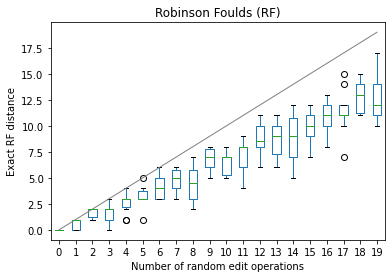

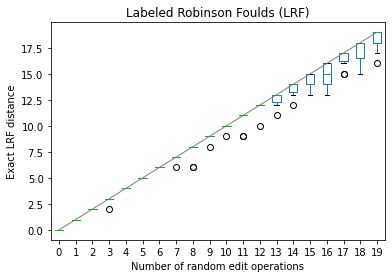

In [163]:
x = np.array(res_rf)
y = x.transpose()
df = pd.DataFrame(y)
#print('Standard Robinson Foulds:')

p1 = df.plot.box()
p1.set_title('Robinson Foulds (RF)')
p1.set_xlabel('Number of random edit operations')
p1.set_ylabel('Exact RF distance')
#z = np.linspace(*p1.get_xlim())
p1.plot(list(range(1,ndist+1)), list(range(0,ndist)), color = 'grey', linewidth = 1)
o1 = p1.get_figure()
o1.savefig('RF.pdf')

x = np.array(res_s)
y = x.transpose()
df = pd.DataFrame(y)
#print('Labelled Robinson Foulds:')
#df.plot.box()

p3 = df.plot.box()
p3.set_title('Labeled Robinson Foulds (LRF)')
p3.set_xlabel('Number of random edit operations')
p3.set_ylabel('Exact LRF distance')
#z = np.linspace(*p2.get_xlim())
p3.plot(list(range(1,ndist+1)), list(range(0,ndist)), color = 'grey', linewidth = 1)
o3 = p3.get_figure()
o3.savefig('LRF.pdf')

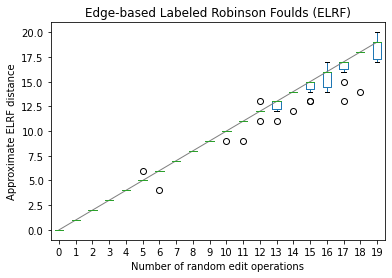

In [161]:
x = np.array(res)
y = x.transpose()
df = pd.DataFrame(y)
#print('Labelled Robinson Foulds:')
#df.plot.box()

p2 = df.plot.box()
p2.set_title('Edge-based Labeled Robinson Foulds (ELRF)')
p2.set_xlabel('Number of random edit operations')
p2.set_ylabel('Approximate ELRF distance')
#z = np.linspace(*p2.get_xlim())
p2.plot(list(range(1,ndist+1)), list(range(0,ndist)), color = 'grey', linewidth = 1)
o2 = p2.get_figure()
o2.savefig('ELRF.pdf')
